## Libraries

In [25]:
import numpy as np
import pandas as pd
from gensim import corpora, models
import spacy
from spacy.lang.en import stop_words
from tqdm import tqdm
from transformers import pipeline
import matplotlib.pyplot as plt

tqdm.pandas()

# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

## Preprocess text

### Filter out non-English documents

In [20]:
# https://huggingface.co/papluca/xlm-roberta-base-language-detection
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df_blogs = pd.read_csv("blogs.csv").dropna(subset="blog")
for i, row in tqdm(df_blogs.iterrows()):
    blog = row["blog"]

    blog = blog.strip()
    lang = pipe(blog, truncation=True)

    df_blogs.loc[i, "blog"] = blog
    df_blogs.loc[i, "lang"] = lang[0]["label"]

df_blogs = df_blogs[df_blogs["lang"] == "en"]
df_blogs.to_csv("blogs.csv")

Device set to use cpu
3138it [58:25,  1.12s/it]


### Apply standard preprocessing

In [70]:
stop_words_to_use = list(stop_words.STOP_WORDS)
stop_words_to_use += ["ride", "rides", "riding", "cycling", "bycycling", "tour", "touring", "day", "bike", "bikes", "road", "get", "go", "mile", "miles", "km", "kms", "metre", "like", "way", "good", "come", "look", "nice", "think", "trip", "know", "see", "great", "today", "distance", "malawi", "zambia", "auckland", "strasbourg", "pyrenees", "bordeaux", "andorra", "paris", "france"]

In [38]:
# https://spacy.io/usage/linguistic-features


def preprocess_text(file_path, nlp, stop_word_removal=True, non_alpha_removal=True, lemmatization=True, lowercasing=True, stop_words_to_use=[]):
    df_blogs = pd.read_csv(file_path)
    documents = []

    for i, row in tqdm(df_blogs.iterrows()):
        doc = nlp(row["blog"]) # Convert to spaCy doc

        if len(doc) > 1:
            if non_alpha_removal: # Remove non alpha characters
                doc = [token for token in doc if token.is_alpha]

            if lemmatization: # Lemmatize words
                doc = [token.lemma_ for token in doc]

            if stop_word_removal: # Remove stop words
                doc = [token for token in doc if token not in stop_words_to_use]

            if lowercasing: # Lowercase words
                doc = [token.lower() for token in doc]

            documents.append(doc)

    # https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2) # Filter out tokens appearing only once
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    dictionary.save("dictionary.dict")
    corpora.MmCorpus.serialize("corpus.mm", corpus)


preprocess_text("blogs.csv", nlp, stop_words_to_use=stop_words_to_use)


## Explore dictionary

In [22]:
# https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html
dictionary = corpora.Dictionary.load("dictionary.dict")
corpus = corpora.MmCorpus("corpus.mm")

word_freq = {k: v for k, v in sorted(dictionary.cfs.items(), key=lambda item: item[1], reverse=True)}
for id in list(word_freq.keys())[:50]:
    print(dictionary[id])

stop
town
find
start
hill
head
little
leave
pass
place
night
turn
long
wind
rain
people
lot
climb
right
park
feel
route
big
hour
river
water
bit
want
tell
thing
eat
end
home
new
stay
pretty
area
camp
decide
use
lunch
walk
old
morning
work
meet
rest
try
far
couple


## Modelling

In [23]:
import logging
import re

# Allow logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)


def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass


def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile(r'(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

### Modelling

Topic 0: gum, nugget, excerpt, emu, fossil, ochoco, dayville, sumpter, berea, perth
Topic 1: mckinsey, finn, butte, celebration, elevation, beau, gain, encouraging, chester, casino
Topic 2: springbrook, simon, rosalia, boone, fairground, brooks, bugger, hillsboro, kg, hobart
Topic 3: savour, hangover, faithful, invermere, newcastle, gin, stuart, link, erie, jen
Topic 4: ernie, unity, anglesea, marion, carlsbad, spearfish, part, whitefish, waterfront, spain
Topic 5: guffey, sprocket, blah, cochrane, barbara, carol, london, â, xmas, ernie
Topic 6: sammy, christopher, patrick, bombala, lander, alison, photo, charlottesville, napier, kirby
Topic 7: roadside, falls, clark, ern, missouri, anna, texas, flower, joyce, phil
Topic 8: melbourne, francois, rotorua, st, jean, h, molly, pj, km, total
Topic 9: start, climb, river, find, wind, pass, stop, rain, hill, town


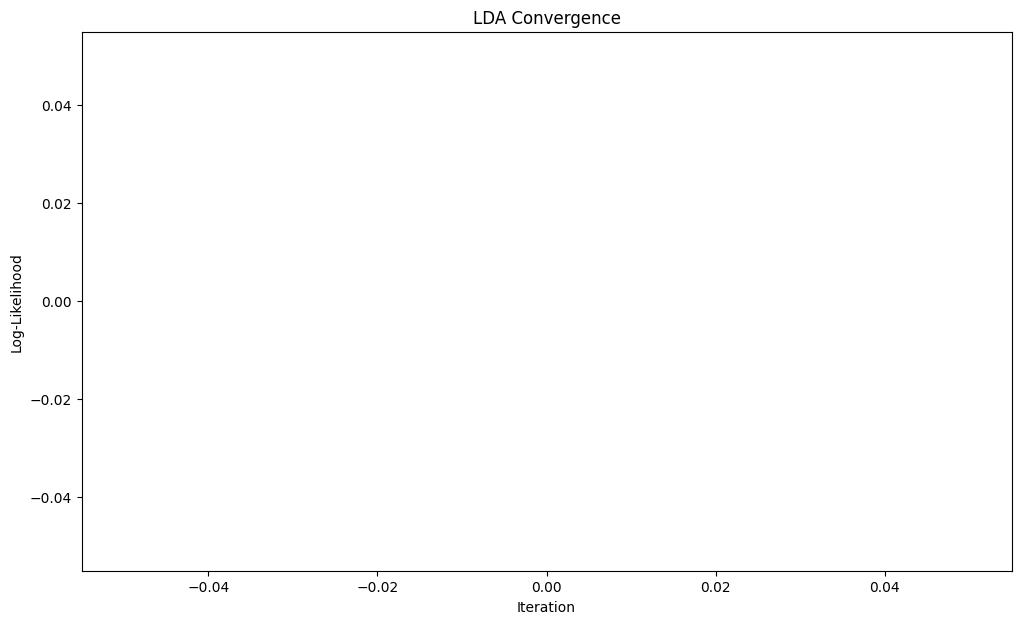

In [27]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# # https://radimrehurek.com/gensim/models/ldamodel.html
clear_logfile()
lda = models.LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=100)
likelihoods = parse_logfile()

# Plot likelihoods for convergence
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(likelihoods)
ax.set(title="LDA Convergence", xlabel="Iteration", ylabel="Log-Likelihood")

# Print most important words per topic
topics = lda.get_topics()
for topic in range(10):
    topic_probs = topics[topic, :]
    print(f"Topic {topic}: {', '.join([dictionary[i] for i in np.argsort(topic_probs)[-10:]])}")

In [58]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

# !pip install bertopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from bertopic import BERTopic

In [ ]:
df_blogs = df_blogs.reset_index(drop=True)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df_blogs.blog)

In [71]:
hdbscan_model = HDBSCAN(min_cluster_size=50) # Clustering step
vectorizer_model = CountVectorizer(stop_words=stop_words_to_use) # Tokenizer step
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # c-TF-IDF step
representation_model = KeyBERTInspired() # Fine-tuning step
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)
topics, probs = topic_model.fit_transform(df_blogs.blog, embeddings)

In [72]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1352,-1_campground_lake_hills_park,"[campground, lake, hills, park, climb, camp, l...",[The Data: Miles: 87.00Time: 8:43:14 (many)Max...
1,0,1560,0_trail_highway_park_campground,"[trail, highway, park, campground, downhill, h...",[It was real foggy out this morning. Before ...
2,1,55,1_trips_bicycling_biking_bicycle,"[trips, bicycling, biking, bicycle, vacation, ...",[My wife wasn't overly thrilled about it; how...


In [46]:
topic_model.visualize_topics()

IndexError: arrays used as indices must be of integer (or boolean) type